In [51]:
import os
import sys
import torch
import numpy as np
import json
import pytorch3d

In [52]:
import matplotlib.pyplot as plt
from skimage.io import imread
from utils import *

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    FoVOrthographicCameras, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    HardPhongShader,
    TexturesVertex,
    TexturesAtlas,
    PointsRenderer,
    PointsRasterizationSettings,
    PointsRasterizer
)

In [53]:
# Set our device:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [54]:
params = Params("params_demo.json")
obj_filename = params.obj_filename

In [55]:
from iopath.common.file_io import PathManager
from pytorch3d.io import IO, ply_io

ply_mesh = ply_io.MeshPlyFormat()
capsule_mesh = ply_mesh.read(
    "data/lm_models/obj_000005.ply",
    True,
    device,
    PathManager())

In [56]:
# Initialize the camera with camera distance, elevation, and azimuth angle
R, T = look_at_view_transform(dist = params.camera_dist, elev = 
                              params.elevation, azim = params.azim_angle) 
print(R.shape, T.shape)

cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256 based on config.json 
raster_settings = RasterizationSettings(
    image_size = (480, 640), 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )

torch.Size([1, 3, 3]) torch.Size([1, 3])


In [57]:
# The textured phong shader interpolates the texture uv coordinates for 
# each vertex, and samples from a texture image.
shader = HardPhongShader(device = device, cameras = cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

(-0.5, 639.5, 479.5, -0.5)

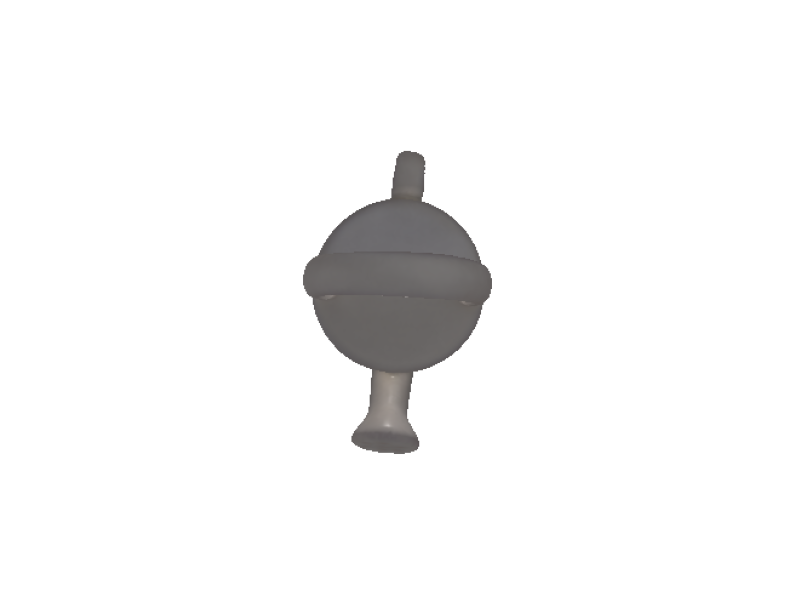

In [58]:
# Render Meshes object
image = renderer(capsule_mesh)
# Plot rendered image
plt.figure(figsize=(10, 10))
plt.imshow(image[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

In [59]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 16

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = params.camera_dist, elev = elev, azim = azim)
print(R.shape, T.shape)

cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

torch.Size([16, 3, 3]) torch.Size([16, 3])


In [60]:
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)
print(images.shape)

torch.Size([16, 480, 640, 4])


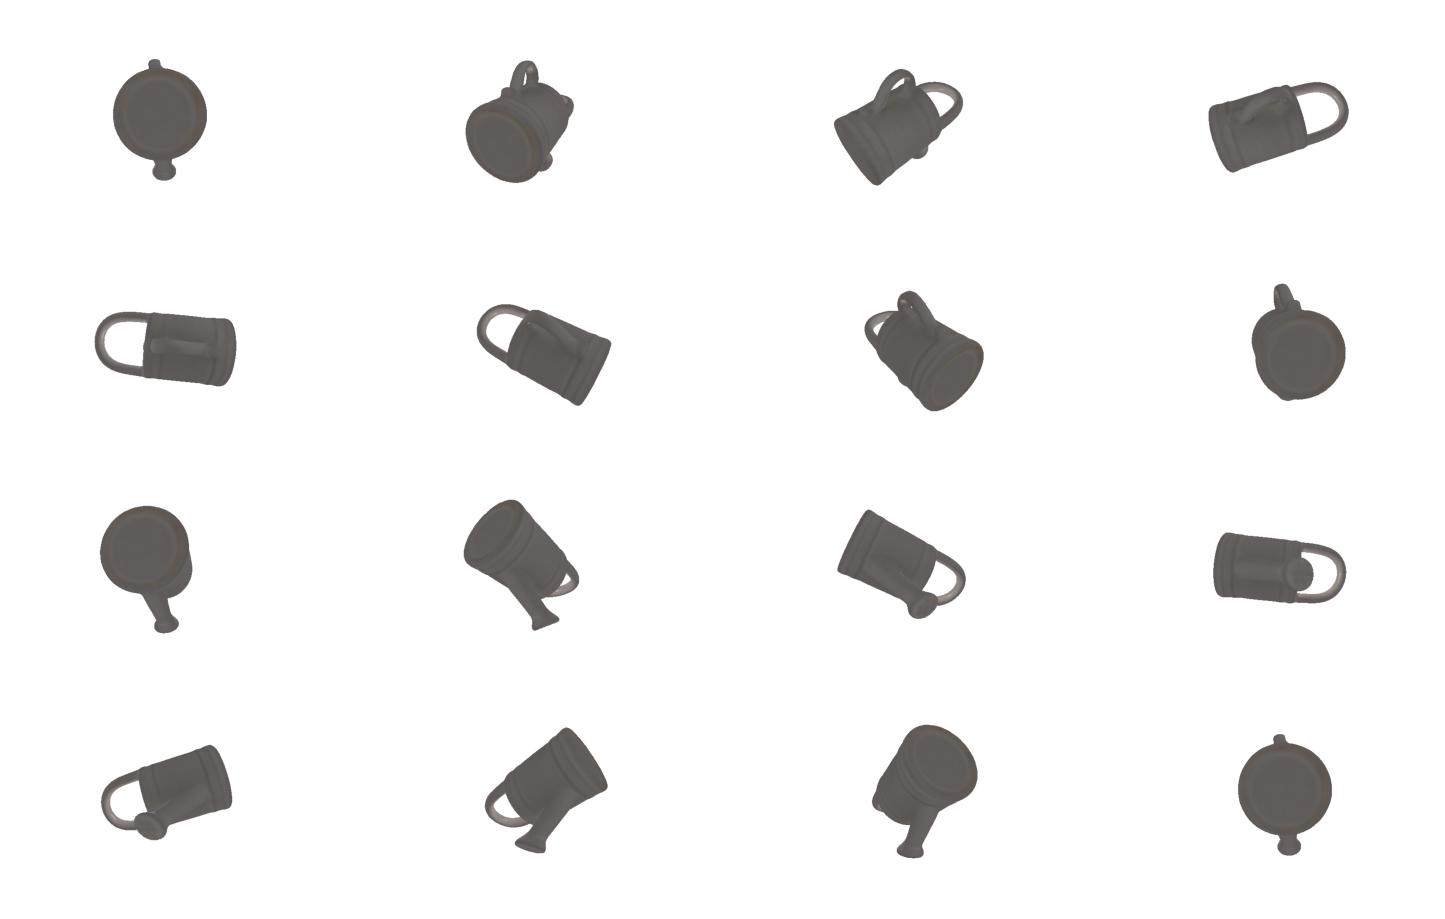

In [61]:
# Plot the rendered images
image_grid(images.cpu().numpy(), rows=int(np.sqrt(batch_size)), cols=int(np.sqrt(batch_size)), rgb=True)

In [62]:
elev

tensor([  0.,  24.,  48.,  72.,  96., 120., 144., 168., 192., 216., 240., 264.,
        288., 312., 336., 360.])

In [63]:
azim

tensor([-180., -156., -132., -108.,  -84.,  -60.,  -36.,  -12.,   12.,   36.,
          60.,   84.,  108.,  132.,  156.,  180.])